## EDA & Imputation

**EDA:**

1. Plots about how variables do not differ between those MSA with 11 and those without
2. Plot about geographic differences between those with 11 and those without
3. Plots of murder vs Census
4. Plot of top 10 murder by MSA and by State 
5. Trend of Year and Murder

**Imputation**

The imputation needs of Puerto Rico were going to be too great, so we decided to restrict our focus to just the continental United States.

Detailed Imputation Strategies are already in the notebook. Make sure that we emphasize that we used linear interpolation within MSA


After applying imputation strategy, the only numeric variables that were still missing were the crime variables within the largest city of the Carson City MSA and the unemployment data for Carson City MSA.  We looked up the Carson City MSA and found out that the entire MSA is primarily Carson City. As a result, we just used the MSA-wide crime data for the city wide data as well.

For the unemployment variables, we looked up the annual unemployment rate for Carson City and just used this.


In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

#### Due to both data limitations and because were most interested in continential United States. We are dropping Puerto Rico from our sample and thus our predictions will only hold for continental United States

# of MSA's: 401


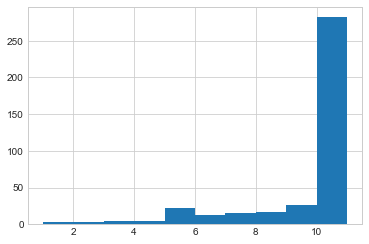

In [2]:
# Load in final dataframe without imputed values
final_df = pd.read_json("output/final.json")

print("# of MSA's: %i" %len(final_df['join_key'].unique()))
final_df['num_years'] = final_df.groupby('join_key')['year'].transform(len)

final_df = final_df.loc[~final_df['state_key'].str.contains("PR"), :]

groups = final_df.loc[:, ['join_key', 'num_years']].drop_duplicates()
plt.hist(groups['num_years'])


# Fow now we are taking those that have all years
full_msa = final_df.num_years == 11

In [3]:
# Quick to look at differences between full MSA and non
def compare_msa(var, ax, max_value):
    ax.hist(final_df.loc[full_msa, var], range=(0, max_value), alpha=0.5, label='11')
    ax.hist(final_df.loc[~full_msa, var], range=(0, max_value), alpha=0.5, label='<11')
    ax.set_title("%s Histogram" %var)
    ax.legend();

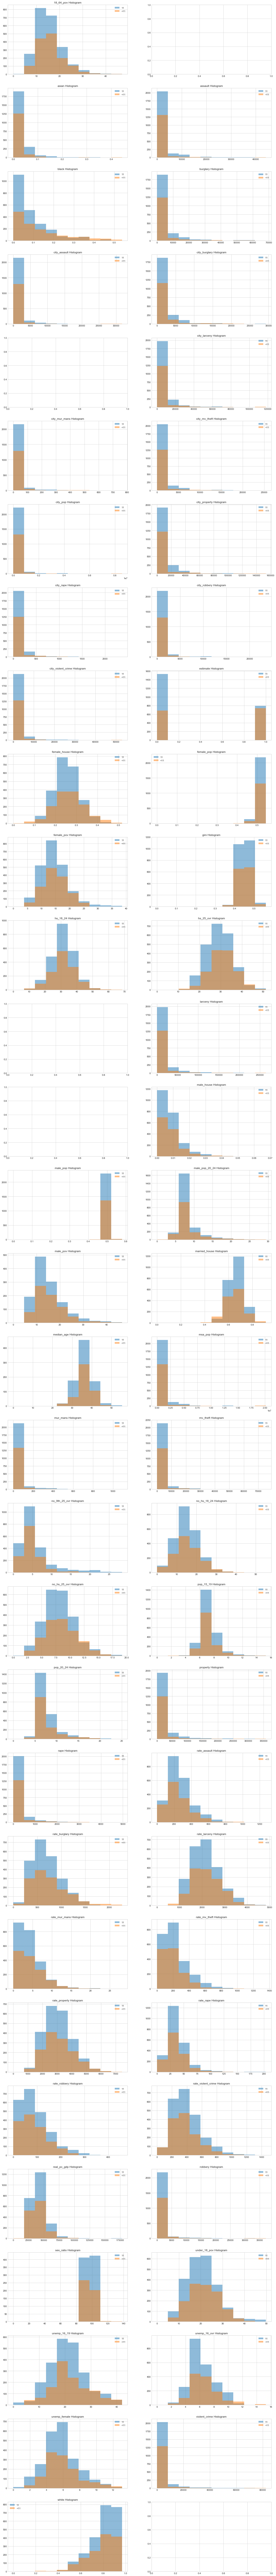

In [4]:
# Look at Differences for MSA that have all years and ones that do not
fig, ax = plt.subplots(31,2, figsize=(20,200))
ax = ax.flatten()
graph_vars = [v for v in final_df.columns 
              if "state_" not in v and "MSA_" not in v and 'year' not in v]
for i, v in enumerate(graph_vars):
    if v not in ['city_key', 'MSA', 'state_key', 'join_key', 'largest_city']:
        compare_msa(v, ax[i], final_df.loc[:, v].max())

### Examining Differences in States between MSA with full years and non-years

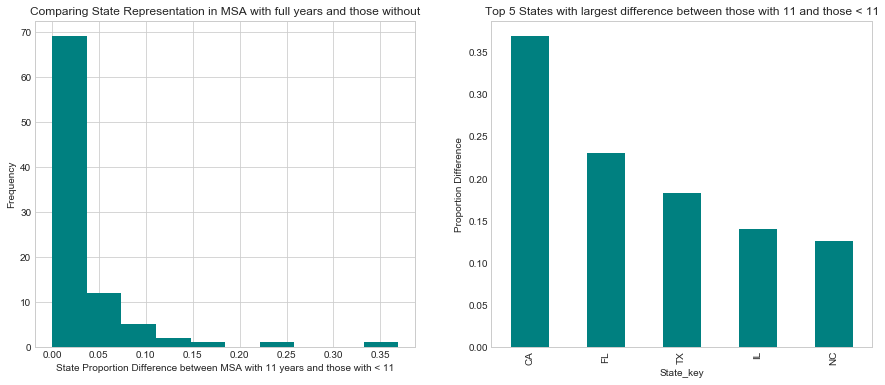

In [5]:
# Look at Differences by states
msa_11 =  final_df.loc[full_msa, ['city_key', 'state_key']].drop_duplicates()
msa_11_counts = msa_11.state_key.value_counts()
msa_11_pct  = pd.DataFrame(msa_11_counts / len(msa_11_counts))
msa_11_pct = msa_11_pct.rename(index=str, columns={'state_key': 'prop_11'})

msa_lt_11 =  final_df.loc[~full_msa, ['city_key', 'state_key']].drop_duplicates()
msa_lt_11_counts = msa_lt_11.state_key.value_counts()
msa_lt_pct = pd.DataFrame(msa_lt_11_counts / len(msa_lt_11_counts))
msa_lt_pct = msa_lt_pct.rename(index=str, columns={'state_key': 'prop_lt_11'})

compare = msa_11_pct.join(msa_lt_pct, how='outer')
compare.loc[compare.prop_11.isnull(), 'prop_11'] = 0
compare.loc[compare.prop_lt_11.isnull(), 'prop_lt_11'] = 0
compare['diff'] = abs(compare['prop_11'] - compare['prop_lt_11'])
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].set_xlabel("State Proportion Difference between MSA with 11 years and those with < 11")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Comparing State Representation in MSA with full years and those without")
ax[0].hist(compare['diff'], color='teal');

ax[1].set_xlabel("State_key")
ax[1].set_ylabel("Proportion Difference")
ax[1].set_title("Top 5 States with largest difference between those with 11 and those < 11")
ax[1] = compare.sort_values("diff", ascending=False).iloc[0:5, 2].plot(kind='bar', color='teal', grid=False)
#compare.head(100)

Based on the above plots there is no clear sytematic difference between those that have 11 and those that do not. Because our rolling window cross validation needs lots of years, we are going to keep the dataframes that have all 11 years

In [6]:
final_df = final_df.loc[full_msa, :]
del final_df['num_years']
print(final_df.shape)

(2321, 565)


In [7]:
"""
Function
-------
x_y_scatter

This function plots a scatter plot between two variables with
certain stylings
"""
def x_y_scatter(x_var, y_var, x_label, y_label, title, ax):
    ax.scatter(x_var, y_var, color='teal', alpha=0.5)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14);

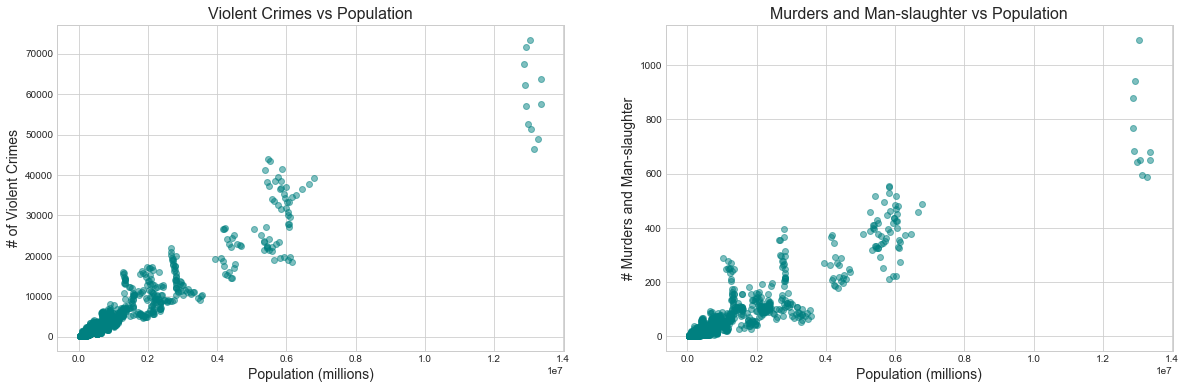

In [8]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
x_y_scatter(final_df['msa_pop'],
           final_df['violent_crime'],
           x_label='Population (millions)',
           y_label='# of Violent Crimes',
           title='Violent Crimes vs Population',
           ax=ax[0])
x_y_scatter(final_df['msa_pop'],
           final_df['mur_mans'],
           x_label='Population (millions)',
           y_label='# Murders and Man-slaughter',
           title='Murders and Man-slaughter vs Population',
           ax=ax[1])

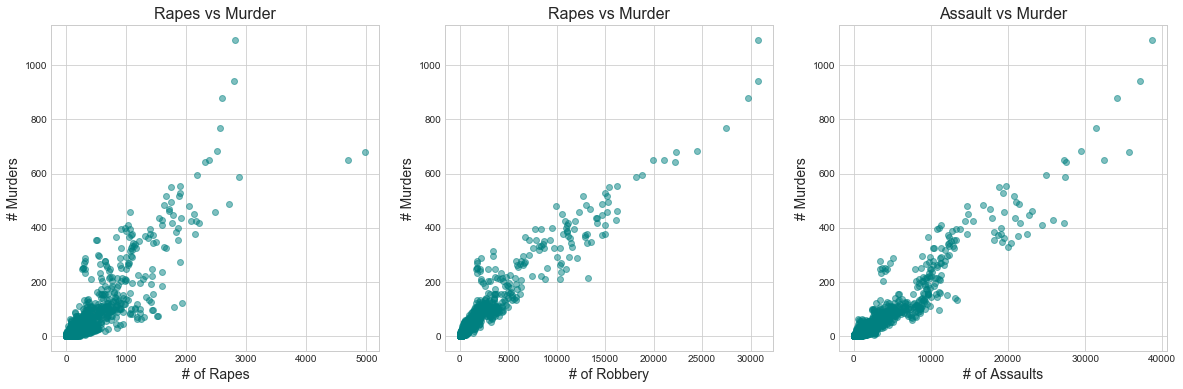

In [9]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,3,figsize=(20,6))

# Rape
x_y_scatter(final_df['rape'],
           final_df['mur_mans'],
           x_label='# of Rapes',
           y_label='# Murders',
           title='Rapes vs Murder',
           ax=ax[0])

# Robbery
x_y_scatter(final_df['robbery'],
           final_df['mur_mans'],
           x_label='# of Robbery',
           y_label='# Murders',
           title='Rapes vs Murder',
           ax=ax[1])
# Assault
x_y_scatter(final_df['assault'],
           final_df['mur_mans'],
           x_label='# of Assaults',
           y_label='# Murders',
           title='Assault vs Murder',
           ax=ax[2])

label_size = 13
matplotlib.rcParams['xtick.labelsize'] = label_size
plt.savefig('Murder Other crimes', bbox_inches='tight')

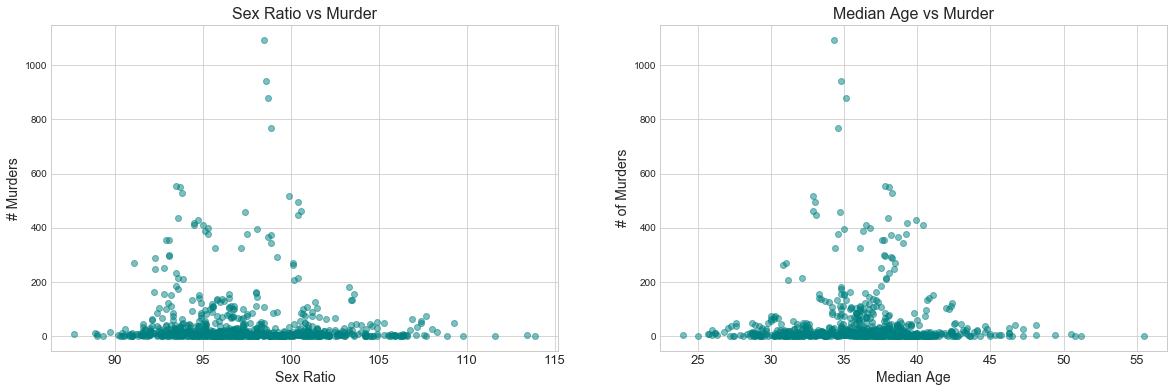

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
x_y_scatter(final_df['sex_ratio'],
           final_df['mur_mans'],
           x_label='Sex Ratio',
           y_label='# Murders',
           title='Sex Ratio vs Murder',
           ax=ax[0])
x_y_scatter(final_df['median_age'],
           final_df['mur_mans'],
           x_label='Median Age',
           y_label='# of Murders',
           title='Median Age vs Murder',
           ax=ax[1])

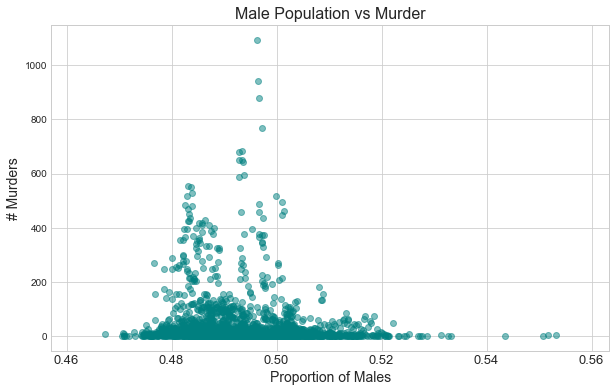

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
x_y_scatter(final_df['male_pop'],
           final_df['mur_mans'],
           x_label='Proportion of Males',
           y_label='# Murders',
           title='Male Population vs Murder',
           ax=ax)

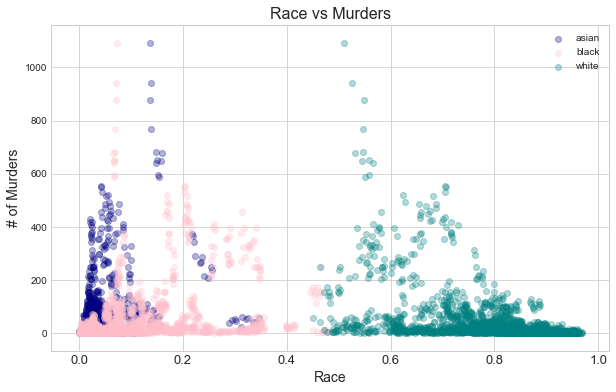

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(final_df['asian'], final_df['mur_mans'], color='navy', alpha=0.3, label='asian')
ax.scatter(final_df['black'], final_df['mur_mans'], color='pink', alpha=0.3, label='black')
ax.scatter(final_df['white'], final_df['mur_mans'], color='teal', alpha=0.3, label='white')
ax.set_title('Race vs Murders', fontsize=16)
ax.set_xlabel('Race', fontsize=14)
ax.set_ylabel('# of Murders', fontsize=14)
ax.legend();

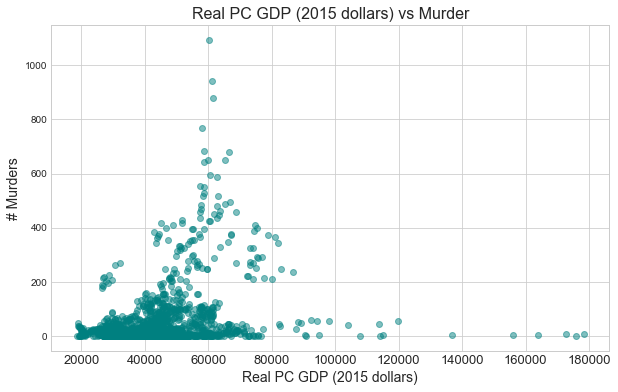

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
x_y_scatter(final_df['real_pc_gdp'],
           final_df['mur_mans'],
           x_label='Real PC GDP (2015 dollars)',
           y_label='# Murders',
           title='Real PC GDP (2015 dollars) vs Murder',
           ax=ax)

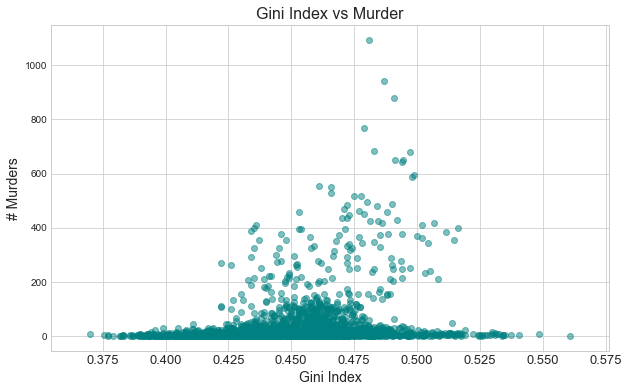

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
x_y_scatter(final_df['gini'],
           final_df['mur_mans'],
           x_label='Gini Index',
           y_label='# Murders',
           title='Gini Index vs Murder',
           ax=ax)
#ax.set_ylim(100,1100);

### Head of Household

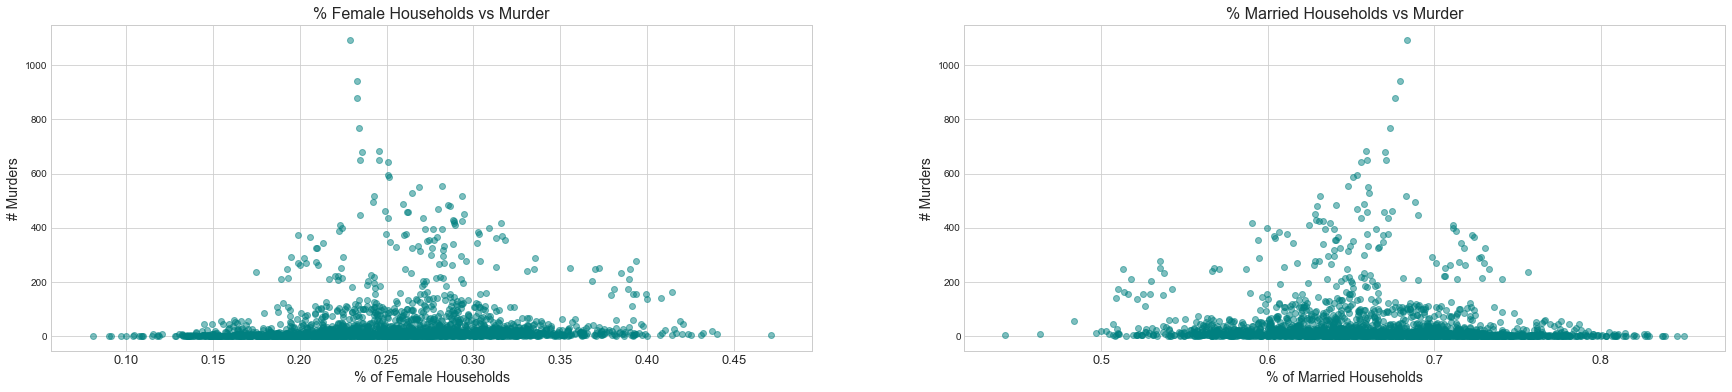

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(30,6))
x_y_scatter(final_df['female_house'],
           final_df['mur_mans'],
           x_label='% of Female Households',
           y_label='# Murders',
           title='% Female Households vs Murder',
           ax=ax[0])

x_y_scatter(final_df['married_house'],
           final_df['mur_mans'],
           x_label='% of Married Households',
           y_label='# Murders',
           title='% Married Households vs Murder',
           ax=ax[1])

In [16]:
'''
Function
----------
scatter_list_murder

This function takes a list of variables and plots each one vs murder

Parameter list:
    var_list - list of strings to plot
    nrows - # of rows in the grid
    ncols - # of cols in grid
    figsize- tuple for figsize

'''
def scatter_list_murder(var_list, nrows, ncols, figsize, log_trans=False):
    fig, ax = plt.subplots(nrows,ncols,figsize=figsize)
    ax = ax.flatten()
    for i, v in enumerate(var_list):
        if log_trans:
            var = np.log(final_df[v])
            label= "Log(" + v + ")"
        else:
            var = final_df[v]
            label = v
            
        
        x_y_scatter(var,
               final_df['mur_mans'],
               x_label=label,
               y_label='# Murders',
               title='%s vs Murder' %v,
               ax=ax[i])
    fig.tight_layout();

### Unemployment Rate

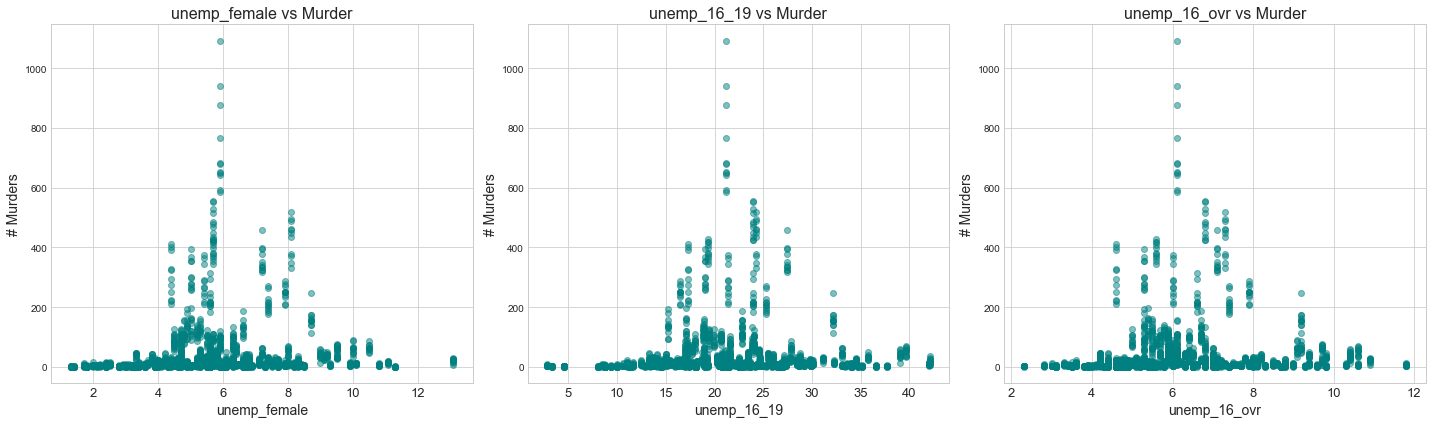

In [17]:
scatter_list_murder(['unemp_female', 'unemp_16_19', 'unemp_16_ovr'],
                    1,3, (20,6))

### Education

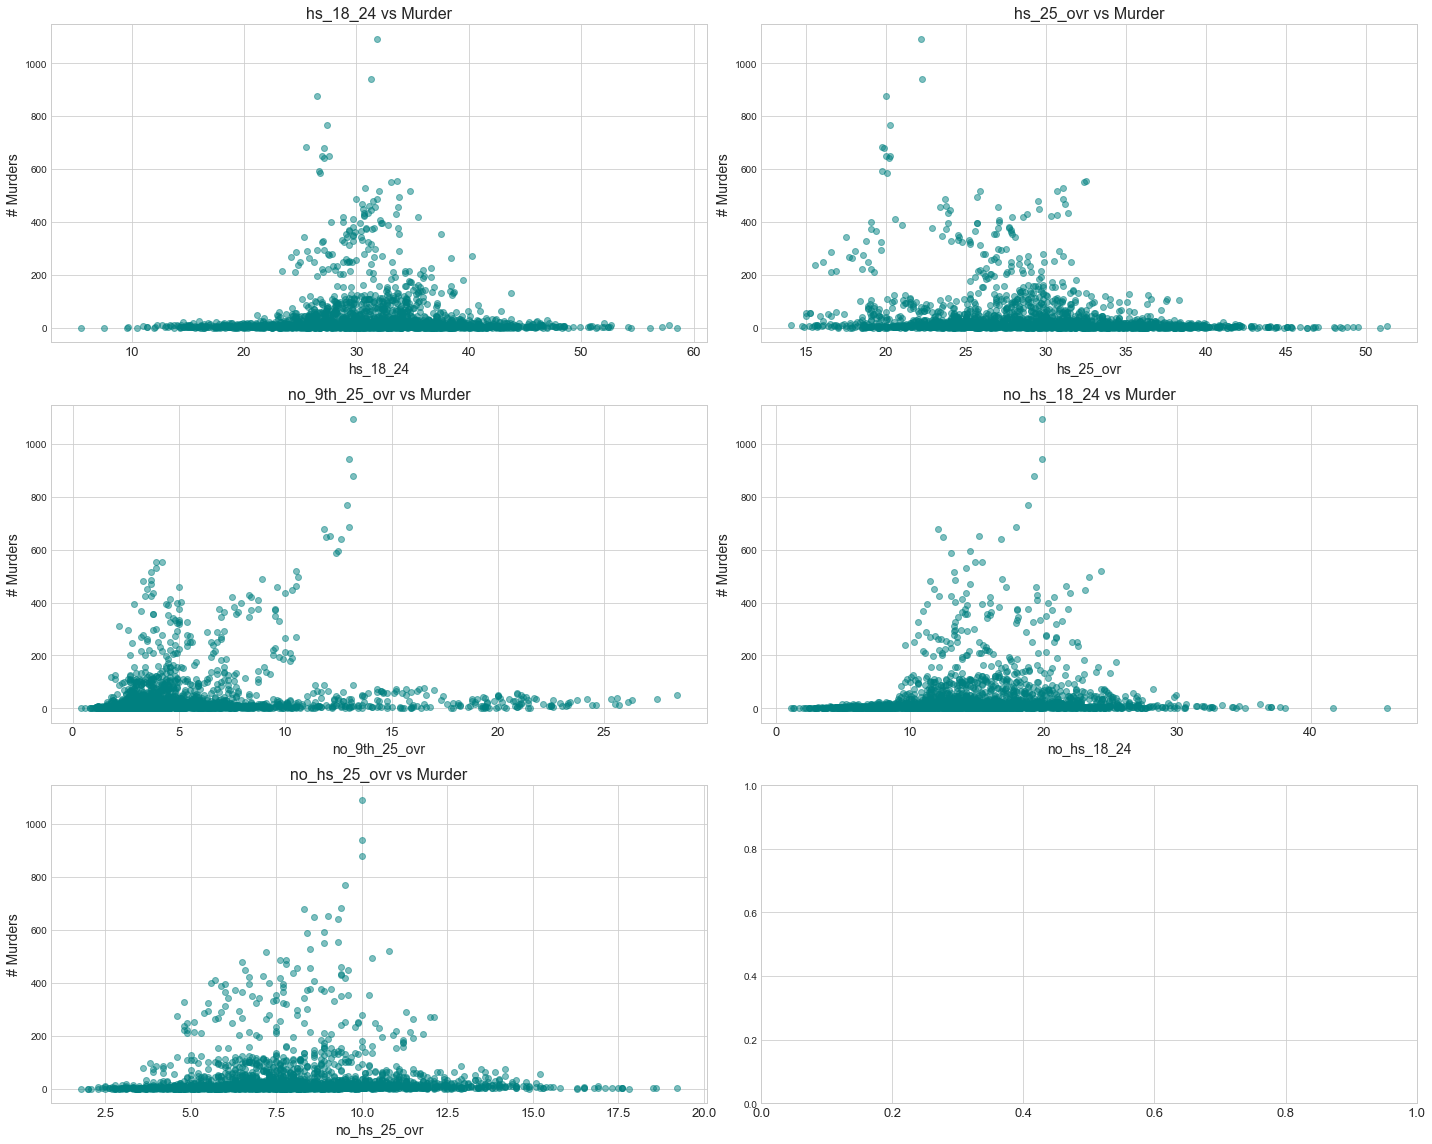

In [18]:
scatter_list_murder(['hs_18_24', 'hs_25_ovr', 'no_9th_25_ovr', 
                     'no_hs_18_24', 'no_hs_25_ovr'],
                    3, 2, (20, 16))

### Poverty

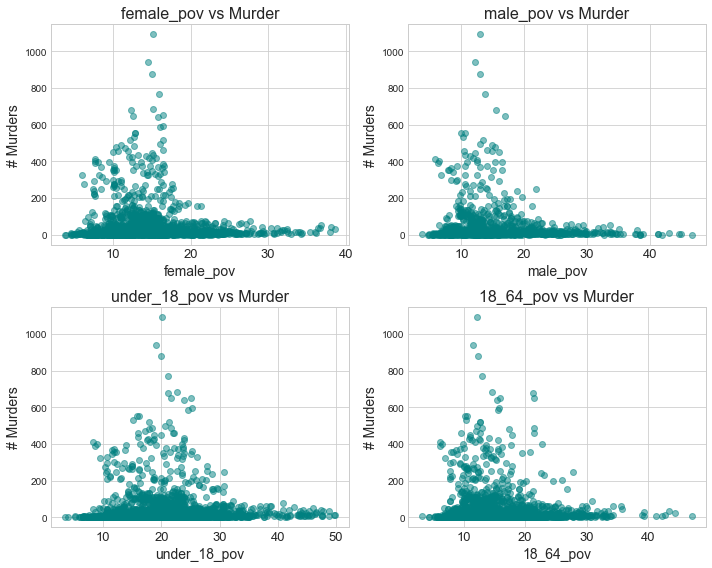

In [19]:
scatter_list_murder(['female_pov', 'male_pov', 'under_18_pov', '18_64_pov'],
                    2, 2, (10, 8), log_trans=False)

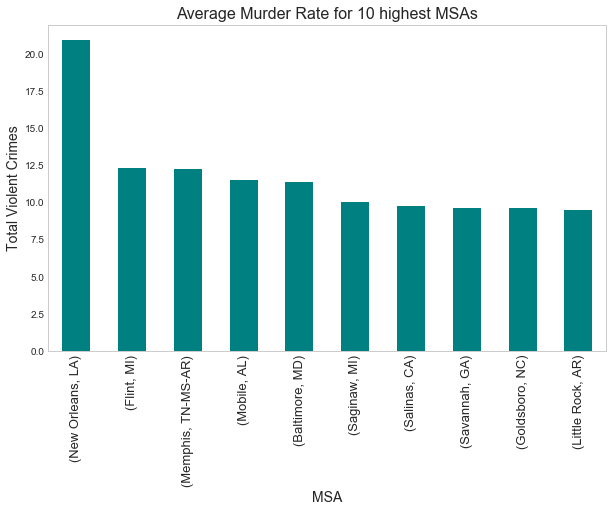

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = final_df.groupby(['city_key', 'state_key'])['rate_mur_mans'].mean().sort_values(
    ascending=False).iloc[0:10].plot(kind='bar', color='teal', grid=False)
ax.set_title('Average Murder Rate for 10 highest MSAs', fontsize=16)
ax.set_xlabel('MSA', fontsize=14)
ax.set_ylabel('Total Violent Crimes',fontsize=14);

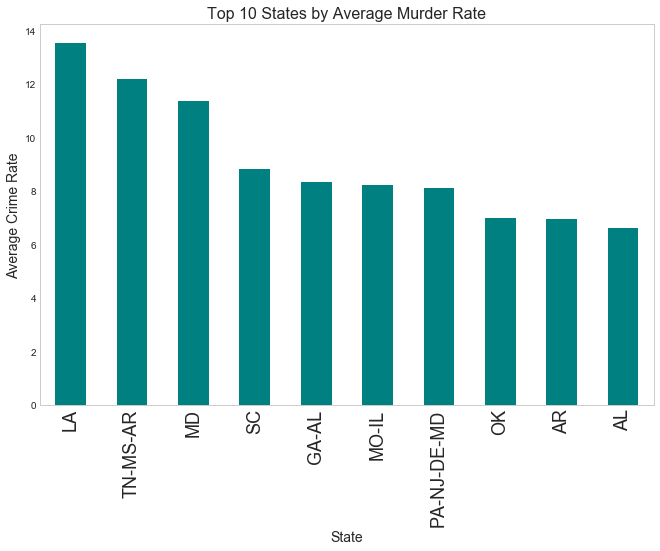

In [21]:
year=2016
label_size = 18
matplotlib.rcParams['xtick.labelsize'] = label_size 
fig, ax = plt.subplots(1,1, figsize=(11,7))
ax=final_df.groupby('state_key')['rate_mur_mans'].mean().sort_values(
    ascending=False).iloc[0:10].plot(kind='bar',grid=False, color='teal')
ax.set_title('Top 10 States by Average Murder Rate', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Average Crime Rate',fontsize=14)
plt.savefig('State_vs_Avg_Crime_rate', bbox_inches='tight')

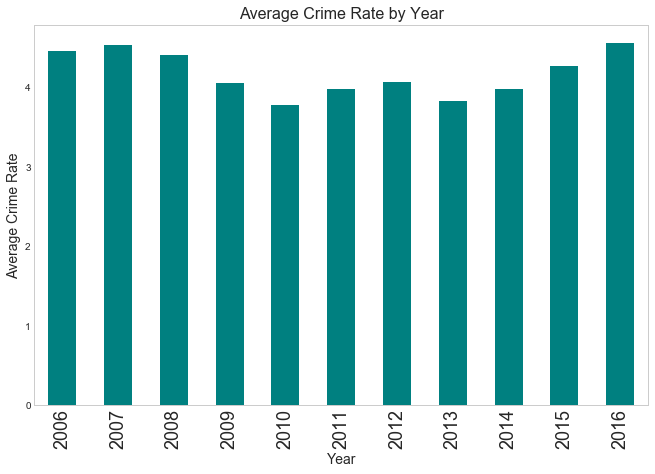

In [22]:
fig, ax = plt.subplots(1,1, figsize=(11,7))
ax=final_df.sort_values("year").groupby('year')['rate_mur_mans'].mean().plot(kind='bar',grid=False, color='teal')
ax.set_title('Average Crime Rate by Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Average Crime Rate',fontsize=14);

We have decided that we will impute data if it's missing less than 25 percent of time. We think will only be able to impute reliably if this is the case

In [23]:
# We feel that we can only impute bariables where 25 % or less is missing.
# You need sufficient data in order to make validd imputation.
miss_vars = []
for v in final_df.columns:
    miss_pct =  np.sum(final_df[v].isnull()) / final_df.shape[0]
    if miss_pct > 0 and miss_pct < 0.25 and v not in ['largest_city']:
        miss_vars.append(v)
    if miss_pct > 0.25:
          del final_df[v]

Here is multiple approaches we are taking for imputation.  Our general approach will be linear interpolation   We will use the previous period's value to impute the current value while adjusting for population growth and using the current MSAs fixed effect. 

This equation is what will be used to impute a variable denoted Y<sub>t</sub>

 $$Y_t = B_0 + B_1 Y_{t-1} + B_2 \frac{Pop_t}{Pop_{t-1}} + B_3 MSA_i $$
 
 We will train the above model where have data and then iteratively fill Y<sub>t</sub> until all are predicted (ie if 2008 an 2009 values are missing. We will train model on all other years, predict 2008 and then predict 2009 using the predicted value for 2008.
 
Now there are may still be missing values for observations with missing history (ex 2006). In this case we we will use the following scheme:

 $$Y_t = Y_{t+1} * \frac{Pop_t}{Pop_{t+1}} $$
 
 
 Imputation Approach # 2: NOT SURE IF WE ARE GOING TO USE THIS APPROACH
 
 $$Y_t = Y_{t-n/t+n} * \frac{Pop_t}{Pop_{t-n/t+n}} $$

In this second approch, we will do simple population adjustment. n represents the number of missing periods we have to go to find the first non-missing data. First, we will go to first lag period (one year before). If that is missing, we will go to year after. Then, two years before then two years after etc

In [24]:
#### SET IMPUTATION STRATEGY HERE
imputation_strategy = 2

In [25]:
final_df = final_df.sort_values(['join_key', 'year'])

#### Generating Population Changes

In [26]:
# Get Population Rate Change
# Generate lag given varname and number of periods
gen_lags = lambda var, num: final_df.groupby(['join_key'])[var].shift(num)
#  Get Lag Year Difference
final_df = final_df.sort_values(['join_key', 'year'])
final_df['lag_year_diff'] = final_df.year -  gen_lags('year', 1)
print(final_df['lag_year_diff'].value_counts(dropna=False))
# Get Lag Population
final_df['lag1_pop_change' ] = final_df['msa_pop'] / gen_lags('msa_pop', 1)

# Get Lead Year Difference
final_df['lead_year_diff'] = final_df.year - gen_lags('year', -1)
print(final_df['lead_year_diff'].value_counts(dropna=False))
# Lead 1 Population
final_df['lead1_pop_change' ] = final_df['msa_pop'] / gen_lags('msa_pop', -1)

del final_df['lead_year_diff']
del final_df['lag_year_diff']

 1.0    2110
NaN      211
Name: lag_year_diff, dtype: int64
-1.0    2110
NaN      211
Name: lead_year_diff, dtype: int64


#### Imputation Strategy # 1

In [27]:
if imputation_strategy == 1:
    print("Executing Strategy 1")
    # Imputation Approach # 1
    for v in miss_vars:
        lag_v = 'lag_%s' %v  
        ############################################
        # While current variable has missing value
        ############################################
        # Using a counter so it does not go infinite loop
        # If missing all 11 values, won't be able to impute
        i = 0
        while np.sum(final_df.loc[:, v].isnull()) > 0:
            # Grab previous period value (either year before or two years)
            final_df[lag_v] = gen_lags(v, 1)
            # Using Lag variable and MSA FE
            x_vars = [v for v in final_df.columns if 'MSA_' in v] +  [lag_v]

            # train - lag not missing v not missing
            # test - lag not missing. v missing
            lag_notnull = final_df[lag_v].notnull()
            train = (final_df[v].notnull()) & (lag_notnull)
            test = (final_df[v].isnull()) & (lag_notnull)

            # If there are situations where v is missing
            # but lag is also missing for all. We cannot do anything
            # we will have to use future data
            if np.sum(test) == 0 or i == 11:
                break
            # Only have to run regression once - Then iteratively fill using coefficeints
            if i == 0:
                lin_reg = LinearRegression().fit(final_df.loc[train, x_vars], final_df.loc[train, v])

            i = i + 1
            # Fill in missing data with predictions
            final_df.loc[test, v] = lin_reg.predict(final_df.loc[test, x_vars])
        # Get rid of lag var if you created one
        if lag_v in final_df.columns:
            del final_df[lag_v]
        ##################################
        # Still Missing - Use Future Data
        ##################################
        # Similiar counter. Do not get stuck in infinite loop if all future also missing
        j = 0
        while np.sum(final_df.loc[:, v].isnull()) > 0:
            if j == 11:
                break
            lead_v = 'lead_%s' %v 
            # Get future Value
            final_df[lead_v] = gen_lags(v, -1)
            # Need v to be missing and v in next period to be next missing
            null_v = (final_df[v].isnull()) & (final_df[lead_v].notnull())
            # Yt= Yt+1 * (Pt/Pt+1)
            final_df.loc[null_v, v] = final_df.loc[null_v, lead_v] * final_df.loc[null_v, "lead1_pop_change"]
            j = j + 1
            del final_df[lead_v]

#### Imputation Strategy # 2

In [28]:
'''
Function
---------
adjust_var

Given lag/lead and period This function will return the variable in that lag/lead
period times population change between current period and that period
'''
def adjust_var(df, var, period_num, lead=False):
    if lead:
        period_num = -1 * period_num
    shift_var = "shift_%s" %var
    df.loc[:, shift_var] = gen_lags(var, period_num)
    df.loc[:, 'shift_pop'] = df['msa_pop'] / gen_lags('msa_pop', period_num)
    miss  = df[var].isnull()
    # Fill missing with adjustment
    df.loc[miss, v] = df.loc[miss, shift_var] * df.loc[miss, 'shift_pop']
    del df[shift_var]
    del df['shift_pop']
    return(df)

In [29]:
if imputation_strategy == 2:
    print("Executing Strategy # 2")
    # This we will juse use lead and lag value with population adjustment
    get_missing = lambda v: np.sum(final_df.loc[:, v].isnull())
    # Switch off lag, lead, lag, lead
    for v in miss_vars:
        if get_missing(v) > 0:
            for period in range(1, 11):
                # Do Lags and then lead for each period
                for lead_bool in [False, True]:
                    final_df = adjust_var(final_df, v, period, lead=lead_bool)
                if get_missing(v) == 0:
                    break

Executing Strategy # 2


In [30]:
# Carson City is just a city which is why it doesn't have any of the city variables 
# So we are just going to set Carson cities variables as entire MSA
carson = final_df.city_key.str.contains("Carson")
final_df.loc[carson, ['MSA', 'year']].head(13)
crime_vars = ['violent_crime','mur_mans', 'rape', 'robbery',
             'assault', 'property', 'burglary', 'larceny','mv_theft']
for v in crime_vars:
    final_df.loc[carson, 'city_%s' %v] = final_df.loc[carson, v]
# Fix population
final_df.loc[carson, 'city_pop'] = final_df.loc[carson,'msa_pop']

##### At this point, some MSA who are missing a feature for all years will still be missing

In [31]:
del final_df['lead1_pop_change']
del final_df['lag1_pop_change']

In [32]:
# Unemployment in Carson City is the whole thing that's still missing
# Going to just use annual Carson City unemployment data for all variables
carson_labor = pd.read_excel("data/NVCARS0URN.xls", skiprows=10)
carson_labor['year'] = carson_labor["observation_date"].dt.year
carson_labor = carson_labor.loc[(carson_labor.year >= 2006) & (carson_labor.year <= 2016), :]
annual_stats = list(carson_labor.groupby("year")['NVCARS0URN'].mean())

# Fill in Carson City Crime Stats using Annual Stats
for i, year in enumerate(range(2006, 2017)):
    final_df.loc[(final_df['join_key'] == 'Carson City-NV') & 
                 (final_df.year == year), ['unemp_16_19', 'unemp_16_ovr', 'unemp_female']] = annual_stats[i]

In [33]:
final_df.loc[final_df.join_key == "Carson City-NV", ['join_key', 'year', 'hs_18_24']].head(11)

,join_key,year,hs_18_24
566,Carson City-NV,2006,39.892035
567,Carson City-NV,2007,38.361380
568,Carson City-NV,2008,37.399471
569,Carson City-NV,2009,37.500000
570,Carson City-NV,2010,42.400000
571,Carson City-NV,2011,20.000000
572,Carson City-NV,2012,43.100000
573,Carson City-NV,2013,33.000000
574,Carson City-NV,2014,36.000000
575,Carson City-NV,2015,27.300000


In [34]:
for v in final_df.columns:
    if "MSA_" not in v:
        miss_pct =  np.sum(final_df[v].isnull()) / final_df.shape[0]
        if miss_pct > 0:
            print(v)
            print("MSAs")
            print(final_df.loc[final_df[v].isnull(),'join_key'].unique())

largest_city
MSAs
['Carson City-NV' 'Texarkana-AR-TX']


In [35]:
final_df.to_json('output/final_imputed%i.json' %imputation_strategy)